In [25]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from skfda.preprocessing.dim_reduction import FPCA
import torch
import torch.nn as nndata
import torch.optim as optim
from models_HLS import *
from data_generation_new import *
from utils import *
from training_HLS import *

In [26]:
J = 5
d = 1000
#sigma = np.repeat(1,J)
sigma = 1.0 / np.arange(1, J + 1)
theta1 = 0.8*np.eye(J)
theta2 = 0.8*np.eye(J)
X_coef, F_basis, fd_basis = generate_fma2_coef(J = J, d = d, Sigma = sigma, Theta1 = theta1, Theta2 = theta2, seed = 10)
print(X_coef.shape)

norms of the basis are: [1. 1. 1. 1. 1.]
(1000, 5)


# Compute the true Long run covariance matrix on the Fourier Basis

In [27]:
X_tensor = torch.tensor(X_coef, dtype=torch.float32)

X_tensor.shape

torch.Size([1000, 5])

In [28]:
result = (
    gamma_l(X_tensor, -1) +
    gamma_l(X_tensor, 0) +
    gamma_l(X_tensor, 1) +
    gamma_l(X_tensor, 2) +
    gamma_l(X_tensor, -2)
)
print(f"gamma(1) + gamma(0) + gamma(-1) + gamma(-2) + gamma(2) =\n{result}")
print(torch.trace(result))


gamma(1) + gamma(0) + gamma(-1) + gamma(-2) + gamma(2) =
tensor([[ 6.5729, -0.0436, -0.1761,  0.0128, -0.0245],
        [-0.0436,  1.5123, -0.0329, -0.0583,  0.0158],
        [-0.1761, -0.0329,  0.7691, -0.0234,  0.0285],
        [ 0.0128, -0.0583, -0.0234,  0.4590, -0.0332],
        [-0.0245,  0.0158,  0.0285, -0.0332,  0.2870]])
tensor(9.6003)


In [29]:
round(d**(1/6))

3

In [30]:
cov_weighted_true,_,_ =cov_l(X_tensor , 0, round(d**(1/3)),  "Bartlett")
print((cov_weighted_true * 100).round() / 100)
sum(np.diag(cov_weighted_true))

tensor([[ 5.4700, -0.0800, -0.2900,  0.1000, -0.0300],
        [-0.0800,  1.3100, -0.0300, -0.0100,  0.0300],
        [-0.2900, -0.0300,  0.6700, -0.0200,  0.0200],
        [ 0.1000, -0.0100, -0.0200,  0.4100, -0.0500],
        [-0.0300,  0.0300,  0.0200, -0.0500,  0.2700]])


np.float32(8.132405)

# Conduct FPCA

In [31]:
# Conduct FPCA
num_components = 5
fpca_fbasis = FPCA(n_components=num_components)
fpca_fbasis.fit(fd_basis)
scores = fpca_fbasis.transform(fd_basis)

# Explained variance ratio
print("Explained variance by each PC:", fpca_fbasis.explained_variance_ratio_)
print(sum(fpca_fbasis.explained_variance_ratio_))

Explained variance by each PC: [0.68817074 0.16126803 0.07662744 0.04665747 0.02727632]
0.9999999999999999


/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: divide by zero encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: overflow encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: invalid value encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: divide by zero encountered in matmul
  X.coefficients @ self._j_matrix
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: overflow encountered in matmul
  X.coeffi

In [32]:
E_coef = fpca_fbasis.components_.coefficients 
print(E_coef)
E_coef.shape

[[ 9.99673403e-01 -1.72344936e-02 -1.72899067e-02 -4.80980946e-03
  -5.82961029e-03]
 [ 1.69222575e-02  9.98397937e-01 -3.22330052e-03 -5.37381567e-02
   4.12528038e-03]
 [ 1.72133594e-02 -1.39371012e-03  9.94753634e-01 -7.49633152e-02
   6.74349126e-02]
 [ 6.55900095e-03  5.38691894e-02  8.08784687e-02  9.90983473e-01
  -9.20082543e-02]
 [ 5.23490492e-03  8.36736519e-04 -6.01211360e-02  9.70635526e-02
   9.93446532e-01]]


(5, 5)

In [33]:
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: F_basis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sum(X_coef * beta * I_j, axis=1) + noise

In [34]:
Y_np.shape

(1000,)

In [35]:
scores.shape
print("FPCA score means (should be ~0):", scores.mean(axis=0))

FPCA score means (should be ~0): [ 7.12763182e-17 -3.75255382e-17  2.47579734e-17  2.77555756e-19
  1.43357548e-17]


In [36]:
center_dat = scores
center_dat.shape

(1000, 5)

In [37]:
#df = pd.DataFrame(center_dat)
#df.to_csv("center_dat_fspline.csv", index=False, header=False)

In [38]:
X = torch.tensor(center_dat, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(d, 1)
print(Y.size())

torch.Size([1000, 5])
torch.Size([1000, 1])


# Model adding covariates

In [39]:
# Parameters
porder = 0
band = round(d**(1/3)) # the bandwidth
print(band)

10


In [40]:
kern_type = "Bartlett"
cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type)
cov_weighted

tensor([[ 5.4810, -0.0170, -0.2173,  0.1058,  0.0292],
        [-0.0170,  1.3079, -0.0287,  0.0342,  0.0287],
        [-0.2173, -0.0287,  0.6678, -0.0077, -0.0097],
        [ 0.1058,  0.0342, -0.0077,  0.4146, -0.0324],
        [ 0.0292,  0.0287, -0.0097, -0.0324,  0.2612]])

In [41]:
cov_weighted_np = cov_weighted.detach().numpy()
cov_weighted_transform = E_coef.T @ cov_weighted_np @ E_coef
print("The estimated LR covariance matrix is:")
print(np.round(cov_weighted_transform,4))
print("The trace of the estimated LR covariance matrix is:")
print(sum(np.diag(cov_weighted_transform)))
print("The true LR covariance matrix is:")
print(np.round(cov_weighted_true.detach().numpy(),4))
print("The trace of the true LR covariance matrix is:")
print(sum(np.diag(cov_weighted_true)))

The estimated LR covariance matrix is:
[[ 5.4716 -0.0832 -0.293   0.0996 -0.0253]
 [-0.0832  1.3107 -0.0257 -0.0111  0.0257]
 [-0.293  -0.0257  0.6737 -0.0241  0.0159]
 [ 0.0996 -0.0111 -0.0241  0.4069 -0.0495]
 [-0.0253  0.0257  0.0159 -0.0495  0.2694]]
The trace of the estimated LR covariance matrix is:
8.132407695055011
The true LR covariance matrix is:
[[ 5.4716 -0.0832 -0.293   0.0996 -0.0253]
 [-0.0832  1.3107 -0.0257 -0.0111  0.0257]
 [-0.293  -0.0257  0.6737 -0.0241  0.0159]
 [ 0.0996 -0.0111 -0.0241  0.4069 -0.0495]
 [-0.0253  0.0257  0.0159 -0.0495  0.2694]]
The trace of the true LR covariance matrix is:
8.132405


Stopping early at Epoch [137/5000], Loss: 0.000098

Restoring best model weights...


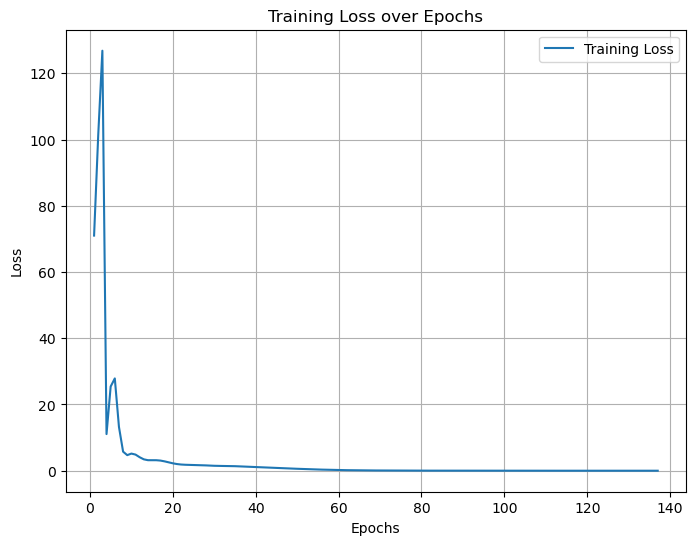

In [42]:
trained_model, losses, best_cov = train_model(
    X=X, Y=Y,
    ModelClass=Model1_new,
    porder=porder,
    band=band,
    kern_type= "Bartlett",
    hidden_dim=64,
    lr=0.01,
    epochs=5000,
    patience=300
)


Shape of Covariance Matrix (NumPy): (5, 5)


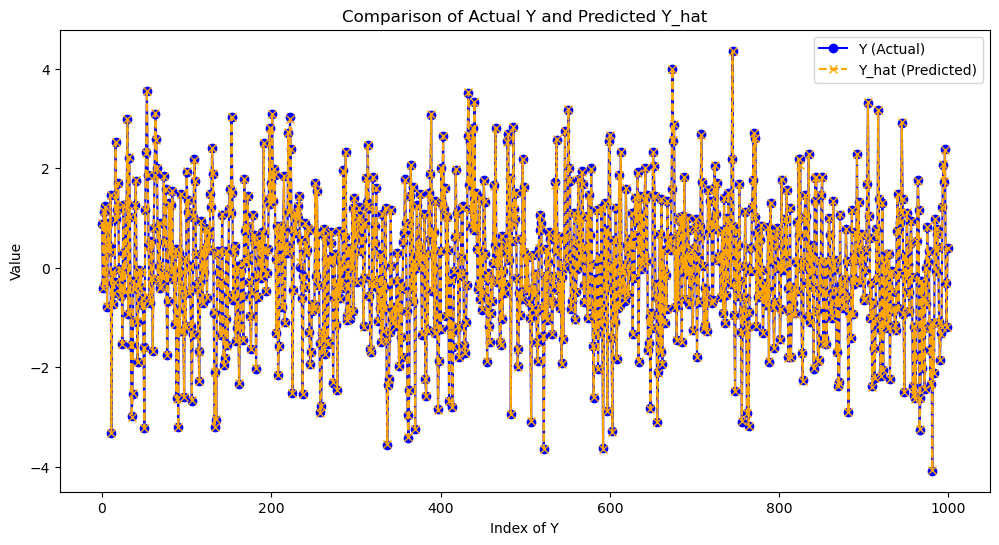

In [43]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
    cov_weighted_np = cov_weighted.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_weighted_np.shape)

    Y_hat = trained_model(X).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()


# Compute true covariance matrix

In [44]:
Sigma2 = np.diag(sigma**2)
g0 = Sigma2 + theta1@Sigma2@theta1.T + theta2@Sigma2@theta2.T
g1 = theta1@Sigma2 + theta2 @ Sigma2 @ theta1.T
g2 = theta2 @ Sigma2
g_1 = Sigma2 @ theta1.T + theta1 @ Sigma2 @ theta2.T
g_2 = Sigma2 @ theta2.T
theoretical_cov_true = g0+g1+g2+g_1+g_2

print(theoretical_cov_true)

[[6.76       0.         0.         0.         0.        ]
 [0.         1.69       0.         0.         0.        ]
 [0.         0.         0.75111111 0.         0.        ]
 [0.         0.         0.         0.4225     0.        ]
 [0.         0.         0.         0.         0.2704    ]]


In [45]:
cov_weighted_np = E_coef.T @ cov_weighted_np @ E_coef
cov_unweighted_np = E_coef.T @ cov_unweighted.detach().numpy() @ E_coef
cov_triple_np = E_coef.T @ cov_triple.detach().numpy() @ E_coef

In [46]:
print("Sum of diagonal (theoratical cov matrix):",np.trace(theoretical_cov_true))
print("Sum of diagonal (true cov matrix from data):", np.trace(cov_weighted_true))
print("Sum of diagonal (estimated cov matrix from kernel sandwich method):",np.trace(cov_weighted_np))
print("Sum of diagonal (estimated cov matrix with all weights =1):",np.trace(cov_unweighted_np))

Sum of diagonal (theoratical cov matrix): 9.894011111111112
Sum of diagonal (true cov matrix from data): 8.132405
Sum of diagonal (estimated cov matrix from kernel sandwich method): 8.132407695055011
Sum of diagonal (estimated cov matrix with all weights =1): 9.148619204759601


In [47]:
diff = cov_weighted_np - theoretical_cov_true
delta = 1.0 / diff.shape[0]  # Assuming uniform grid over [0,1]
squared_norm = np.sum(diff**2) * delta**2
print(squared_norm)

0.08104608456899257


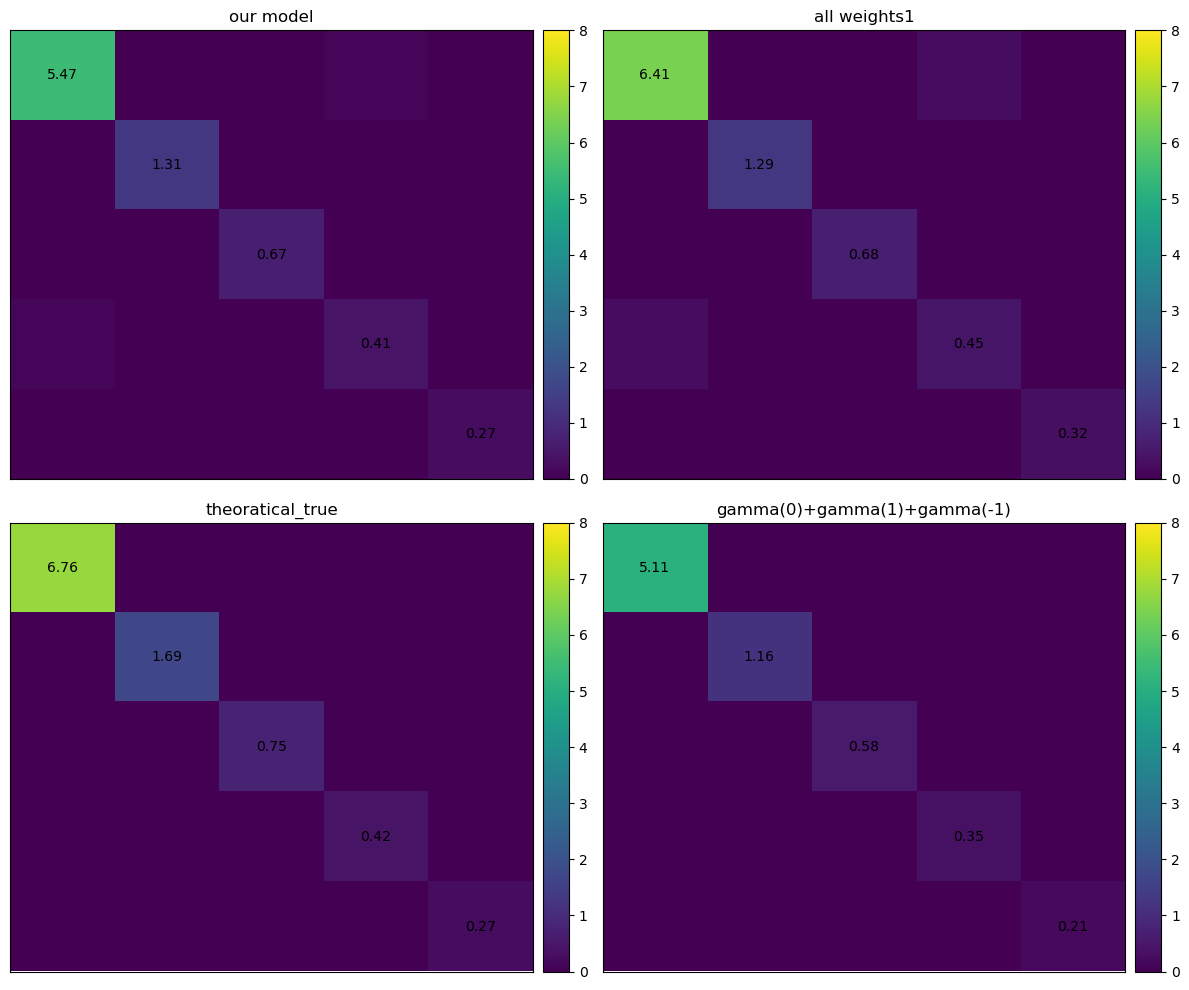

In [48]:
fig = plot_matrices_2d([cov_weighted_np,cov_unweighted_np, theoretical_cov_true, cov_triple_np], titles = ["our model", "all weights1", "theoratical_true", "gamma(0)+gamma(1)+gamma(-1)"])
filename = f"figures/FMA2_J{J}_d{d}_band{band}_kernel{kern_type}.png"
fig.savefig(filename, dpi=300, bbox_inches='tight')